<a href="https://github.com/AngelicaCorrales/recommendation_system_H_M/blob/main/KModes_H%26M_recomendations_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# **Sistema de recomendación usando K-Modes**

Se quiere elaborar un prototipo de un sistema de recomendación de artículos de H&M basado en contenido y teniendo en cuenta el historial de compras de los clientes. 

#**Descargar datasets desde Kaggle**

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

 **Token 1**

In [ ]:
!cp /content/drive/MyDrive/AI/Proyecto_HM/kaggle.json ~/.kaggle/kaggle.json

**Token 2**

In [ ]:
!cp /content/drive/MyDrive/Proyecto_HM/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f transactions_train.csv

 99% 580M/584M [00:16<00:00, 29.1MB/s]
100% 584M/584M [00:16<00:00, 36.2MB/s]


In [ ]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f customers.csv

 91% 89.0M/97.9M [00:01<00:00, 81.6MB/s]
100% 97.9M/97.9M [00:01<00:00, 70.7MB/s]


In [ ]:
! kaggle competitions download h-and-m-personalized-fashion-recommendations -f articles.csv

100% 4.26M/4.26M [00:00<00:00, 42.6MB/s]
100% 4.26M/4.26M [00:00<00:00, 42.4MB/s]


In [ ]:
!unzip transactions_train.csv.zip

Archive:  transactions_train.csv.zip
  inflating: transactions_train.csv  


In [ ]:
!unzip customers.csv.zip

Archive:  customers.csv.zip
  inflating: customers.csv           


In [ ]:
!unzip articles.csv.zip

Archive:  articles.csv.zip
  inflating: articles.csv            


# **Importar librerías necesarias para la exploración**

In [ ]:
#Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 
!pip install kmodes
from kmodes.kmodes import KModes

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.metrics import pairwise_distances_argmin_min

# Preprocesado y modelado
# ==============================================================================
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder

df_articles = pd.read_csv('articles.csv',na_values='?')
df_transactions = pd.read_csv('transactions_train.csv',na_values='?')
df_customers = pd.read_csv('customers.csv',na_values='?')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Organización y limpieza de los datos**

In [ ]:
#Copias de los dataframes originales para su respectiva modificación
df_custClean=df_customers.copy()
df_tranClean=df_transactions.copy()
df_articles_copy=df_articles.copy() 

In [ ]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

In [ ]:
class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self):
        return self
    def transform(self, df):
        df.drop(columns=self.variables, axis=1, inplace=True)
        return df

In [ ]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, column, currentValues, newValue):
        self.column = column
        self.currentValues = currentValues
        self.newValue = newValue
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].replace(self.currentValues, self.newValue, inplace=True)
        return df

In [ ]:
class DropNaNValues(BaseEstimator, TransformerMixin):
    def fit(self):
        return self
    def transform(self, df):
        df=df.dropna()
        df=df.reset_index(drop=True)
        return df    

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column, factor=1.5):
        self.factor = factor
        self.column=column
    def fit(self):
        return self
    def transform(self, df):
        q1 = np.quantile(df[self.column].values, 0.25)
        q3 = np.quantile(df[self.column].values, 0.75)
        iqr = q3 - q1
        upper_bound = q3 + (self.factor * iqr)
        lower_bound = q1 - (self.factor * iqr)
        outliers = df[self.column].values[(df[self.column].values <= lower_bound) | (df[self.column].values >= upper_bound)]
        if ((outliers.size*100)/(df[self.column].count()))<10:
            df = df[~df[self.column].isin(outliers)]
            df = df.reset_index(drop=True)
        return df

In [ ]:
class DropDuplicatedValues(BaseEstimator, TransformerMixin):
    def fit(self):
        return self
    def transform(self, df):
        df.drop_duplicates()
        df.reset_index(drop=True)
        return df

In [ ]:
class TypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, column, newType):
        self.column=column
        self.newType=newType
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].astype(self.newType)
        return df

In [ ]:
class OneHotEncoderWithoutDummiesCustom(BaseEstimator, TransformerMixin):
    def __init__(self,column, ZeroCondition):
        self.column = column
        self.ZeroCondition = ZeroCondition
        self.value= 0
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].replace(self.ZeroCondition, self.value, inplace = True)
        df[self.column].replace(to_replace = r'^(?!'+self.ZeroCondition+').*$', value = 1, regex = True, inplace = True)
        return df

In [ ]:
class LabelEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        
    def fit(self):
        return self
    
    def transform(self, df):
        le = LabelEncoder()
        for i in self.variables:
          df[i] = le.fit_transform(df[i])
        return df

In [ ]:
class transactionsDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropper_duplicate = DropDuplicatedValues()
        self.outlier_remover = OutlierRemover('price')
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropper_duplicate.transform(df)
        df = self.outlier_remover.transform(df)
        return df

In [ ]:
class customerDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropper_column = DropFeatureSelector(['postal_code'])
        self.replace_FN_NaN = ValueReplacer("FN", np.nan,0)
        self.replace_Active_NaN = ValueReplacer("Active", np.nan,0)
        self.replace_member_state = ValueReplacer("club_member_status", ["LEFT CLUB", "PRE-CREATE"], "INACTIVE")
        self.replace_member_state_NaN = ValueReplacer("club_member_status", np.nan,"INACTIVE")
        self.replace_fNews_NONE= ValueReplacer("fashion_news_frequency", "NONE","Never")
        self.replace_fNews_None= ValueReplacer("fashion_news_frequency", "None","Never")
        self.replace_fNews_NaN= ValueReplacer("fashion_news_frequency",np.nan, "Never")
        self.replace_fNews_Monthly= ValueReplacer("fashion_news_frequency","Monthly", "Regularly")
        self.dropperNan = DropNaNValues()
        self.outlier_remover = OutlierRemover('age')
        self.type_converter_Active = TypeConverter('Active','int64')
        self.type_converter_FN = TypeConverter('FN','int64')
        self.oneHot_encoder_mStatus = OneHotEncoderWithoutDummiesCustom("club_member_status","INACTIVE")
        self.oneHot_encoder_fNews = OneHotEncoderWithoutDummiesCustom("fashion_news_frequency","Never")
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropper_column.transform(df)
        df = self.replace_FN_NaN.transform(df)
        df = self.replace_Active_NaN.transform(df)
        df = self.replace_member_state.transform(df)
        df = self.replace_member_state_NaN.transform(df)
        df = self.replace_fNews_NONE.transform(df)
        df = self.replace_fNews_None.transform(df)
        df = self.replace_fNews_NaN.transform(df)
        df = self.replace_fNews_Monthly.transform(df)
        df = self.dropperNan.transform(df)
        df = self.outlier_remover.transform(df)
        df = self.type_converter_Active.transform(df)
        df = self.type_converter_FN.transform(df)
        df = self.oneHot_encoder_mStatus.transform(df)
        df = self.oneHot_encoder_fNews.transform(df)
        return df

In [ ]:
pipeline_customerDatasetCleaning=make_pipeline(
    DropFeatureSelector(['postal_code']),
    ValueReplacer("FN", np.nan,0),
    ValueReplacer("Active", np.nan,0),
    ValueReplacer("club_member_status", ["LEFT CLUB", "PRE-CREATE"], "INACTIVE"),
    ValueReplacer("club_member_status", np.nan,"INACTIVE"),
    ValueReplacer("fashion_news_frequency", "NONE","Never"),
    ValueReplacer("fashion_news_frequency", "None","Never"),
    ValueReplacer("fashion_news_frequency",np.nan, "Never"),
    ValueReplacer("fashion_news_frequency","Monthly", "Regularly"),
    DropNaNValues(),
    OutlierRemover('age'),
    TypeConverter('Active','int64'),
    TypeConverter('FN','int64'),
    OneHotEncoderWithoutDummiesCustom("club_member_status","INACTIVE"),
    OneHotEncoderWithoutDummiesCustom("fashion_news_frequency","Never")
)

In [ ]:
class articlesDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropperNan = DropNaNValues()
        self.dropperCol= DropFeatureSelector(['product_code','prod_name', 'product_type_no', 'graphical_appearance_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no','section_no','garment_group_no', 'detail_desc'])
        self.label_encoder = LabelEncoderCustom(['product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name'])
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropperNan.transform(df)
        df = self.dropperCol.transform(df)
        df = self.label_encoder.transform(df)
        return df

In [ ]:
pipeline_transactionsDatasetCleaning=make_pipeline(
       DropDuplicatedValues(),
       OutlierRemover('price')
)

In [ ]:
pipeline_transactionsDatasetCleaning

Pipeline(steps=[('dropduplicatedvalues', DropDuplicatedValues()),
                ('outlierremover', OutlierRemover(column='price'))])

In [ ]:
pipeline_articlesDatasetCleaning=make_pipeline(
    DropNaNValues(),
    DropFeatureSelector(['product_code','prod_name', 'product_type_no', 'graphical_appearance_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no','section_no','garment_group_no', 'detail_desc']),
    LabelEncoderCustom(['product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name'])
)

In [ ]:
pipeline_articlesDatasetCleaning

Pipeline(steps=[('dropnanvalues', DropNaNValues()),
                ('dropfeatureselector',
                 DropFeatureSelector(variables=['product_code', 'prod_name',
                                                'product_type_no',
                                                'graphical_appearance_no',
                                                'colour_group_code',
                                                'perceived_colour_value_id',
                                                'perceived_colour_master_id',
                                                'department_no', 'index_code',
                                                'index_group_no', 'section_no',
                                                'garment_group_no',
                                                'detail_desc'])),
                ('labelencodercustom',
                 LabelEncoderCustom(variables=['product_type_name',
                                               'product_group_name',
                                               'graphical_appearance_name',
                                               'colour_group_name',
                                               'perceived_colour_value_name',
                                               'perceived_colour_master_name',
                                               'department_name', 'index_name',
                                               'index_group_name',
                                               'section_name',
                                               'garment_group_name']))])

In [ ]:
pipeline_customerDatasetCleaning

Pipeline(steps=[('dropfeatureselector',
                 DropFeatureSelector(variables=['postal_code'])),
                ('valuereplacer-1',
                 ValueReplacer(column='FN', currentValues=nan, newValue=0)),
                ('valuereplacer-2',
                 ValueReplacer(column='Active', currentValues=nan, newValue=0)),
                ('valuereplacer-3',
                 ValueReplacer(column='club_member_status',
                               currentValues=['LEFT CLUB', 'PRE-CREATE'],
                               newVal...
                 TypeConverter(column='Active', newType='int64')),
                ('typeconverter-2',
                 TypeConverter(column='FN', newType='int64')),
                ('onehotencoderwithoutdummiescustom-1',
                 OneHotEncoderWithoutDummiesCustom(ZeroCondition='INACTIVE',
                                                   column='club_member_status')),
                ('onehotencoderwithoutdummiescustom-2',
                 OneHotEncoderWithoutDummiesCustom(ZeroCondition='Never',
                                                   column='fashion_news_frequency'))])

In [ ]:
df_custClean=pipeline_customerDatasetCleaning.transform(df_custClean)

In [ ]:
df_tranClean=pipeline_transactionsDatasetCleaning.transform(df_tranClean)

In [ ]:
df_articles_copy=pipeline_articlesDatasetCleaning.transform(df_articles_copy)

# **Unión de los 3 conjuntos de datos**

In [ ]:
del df_articles
del df_transactions
del df_customers 

In [ ]:
class KeepColumns(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self, df):
        return self
    def transform(self, df):
        X_new = df[self.columns]
        return X_new

In [ ]:
#creating object of KeepColumns class
keep_columns = KeepColumns(["customer_id"])
keep_columns.get_params()

{'columns': ['customer_id']}

In [ ]:
#Cambio del dataframe de clientes por las columnas a conservar
keep_columns.fit(df_custClean)
df_custClean=keep_columns.transform(df_custClean)


In [ ]:
#creating object of KeepColumns class
keep_columns2 = KeepColumns(["customer_id","article_id"])
keep_columns2.get_params()

{'columns': ['customer_id', 'article_id']}

In [ ]:
#Cambio del dataframe de transacciones por las columnas a conservar
keep_columns2.fit(df_tranClean)
df_tranClean=keep_columns2.transform(df_tranClean)

In [ ]:
class KeepLastRows(BaseEstimator, TransformerMixin):
    def __init__(self,indexMin):
        self.indexMin = indexMin
    def fit(self, df):
        return self
    def transform(self, df):
        X_new = df.iloc[self.indexMin:,:]
        return X_new

In [ ]:
#creating object of KeepLastRows class
keep_rows = KeepLastRows(17000000)
keep_rows.get_params()

{'indexMin': 17000000}

In [ ]:
#Cambio del dataframe de transacciones por las filas a conservar
keep_rows.fit(df_tranClean)
df_tranClean=keep_rows.transform(df_tranClean)


In [ ]:
class MergeDataframes(BaseEstimator, TransformerMixin):
    def __init__(self,on):
        self.on =on
    def fit(self):
        return self
    def transform(self, df1,df2):
        X_merged = pd.merge(df1,df2,on=self.on)
        return X_merged

In [ ]:
#creating object of KeepLastRows class
merge_dfs = MergeDataframes("customer_id")
merge_dfs.get_params()

{'on': 'customer_id'}

In [ ]:
#Union de los dataframes de transacciones y clientes
merge_dfs.fit()
df_merged=merge_dfs.transform(df_tranClean,df_custClean)


In [ ]:
class GetFractionSampleDataframe(BaseEstimator, TransformerMixin):
    def __init__(self,fraction):
        self.fraction = fraction
    def fit(self, df):
        return self
    def transform(self, df):
        X_sample = df.sample(frac=self.fraction)
        return X_sample

In [ ]:
#creating object of GetFractionSampleDataframe class
sample_df = GetFractionSampleDataframe(0.10)
sample_df.get_params()

{'fraction': 0.1}

In [ ]:
#Obtención de una porción del dataframe original
sample_df.fit(df_merged)
df_merged=sample_df.transform(df_merged)


In [ ]:
del df_tranClean
del df_custClean

In [ ]:
#creating object of MergeDataframes class
merge_dfs2 = MergeDataframes("article_id")
merge_dfs2.get_params()

{'on': 'article_id'}

In [ ]:
#Union de los dataframes de merged y articulos
merge_dfs2.fit()
df_merged=merge_dfs2.transform(df_merged,df_articles_copy)


In [ ]:
df_merged.shape

(1322001, 13)

In [ ]:
pipeline_merge=make_pipeline(
    keep_columns,
    keep_columns2,
    keep_rows,
    merge_dfs,
    sample_df ,
    merge_dfs2 
)

In [ ]:
pipeline_merge

Pipeline(steps=[('keepcolumns-1', KeepColumns(columns=['customer_id'])),
                ('keepcolumns-2',
                 KeepColumns(columns=['customer_id', 'article_id'])),
                ('keeplastrows', KeepLastRows(indexMin=17000000)),
                ('mergedataframes-1', MergeDataframes(on='customer_id')),
                ('getfractionsampledataframe',
                 GetFractionSampleDataframe(fraction=0.1)),
                ('mergedataframes-2', MergeDataframes(on='article_id'))])

#**Aplicación de clustering**

##**Estimar el valor de k más óptimo**

In [ ]:
principal_df_articles_cluster=df_articles_copy.copy()
principal_df_articles_cluster.drop(["article_id"], axis=1, inplace=True)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1641, cost: 795199.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3111, cost: 753204.0
Run 1, iteration: 2/100, moves: 2445, cost: 753204.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5050, cost: 727753.0
Run 1, iteration: 2/100, moves: 1314, cost: 727753.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3029, cost: 708847.0
Run 1, iteration: 2/100, moves: 1819, cost: 708847.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 3219, cost: 696127.0
Run 1, iteration: 2/100, moves: 1846, cost: 694947.0
Run 1, iteration: 3/100, moves: 473, cost: 694947.0
Init: initializing centroids
Init: initializing clusters
Starting itera

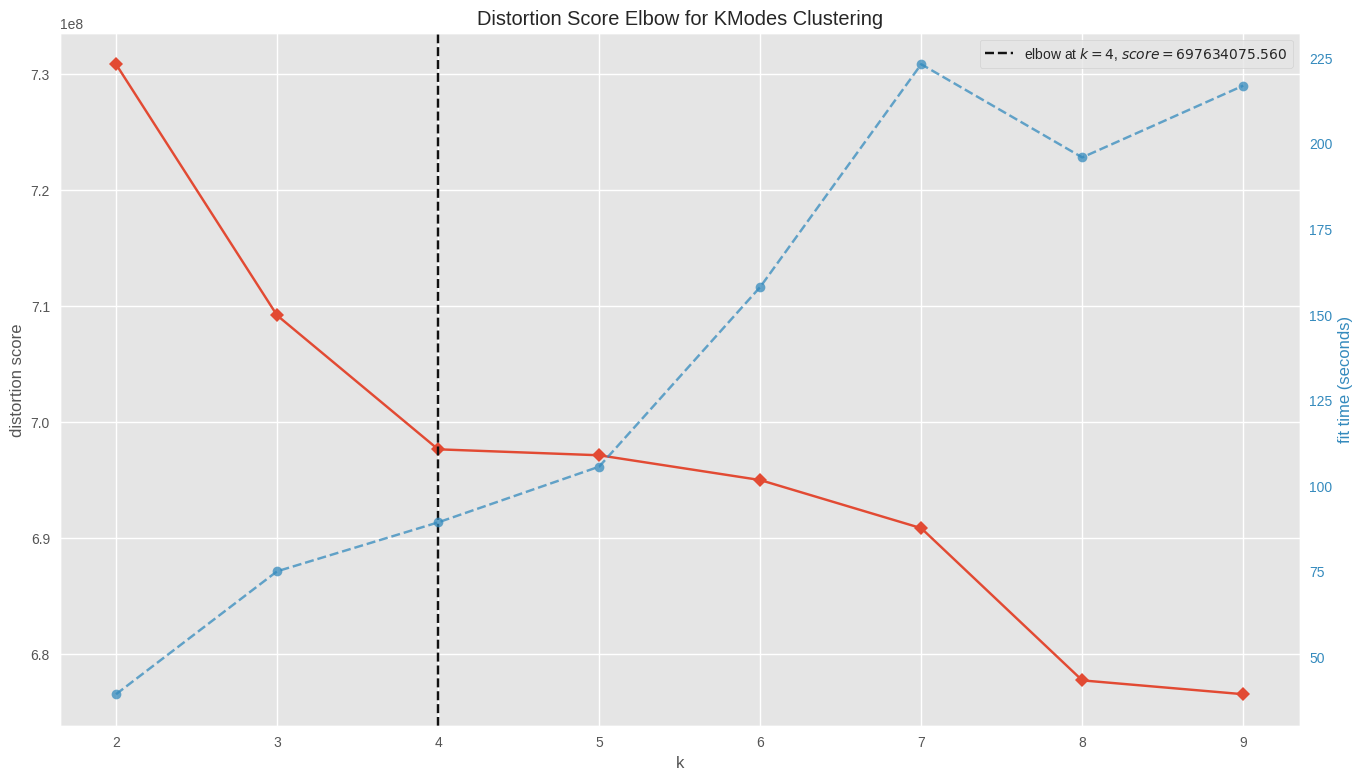

<Axes: title={'center': 'Distortion Score Elbow for KModes Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KModes(init = 'Cao', n_init = 1, verbose=1, random_state=42)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(principal_df_articles_cluster)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

# **Pipeline**

In [ ]:
# Entrenamiento modelo k-means con el valor óptimo encontrado de k

k = 4  #Número de grupos que se escogió después del análisis previo.

modes_pipe = make_pipeline(
                KModes(
                    n_clusters   = k,            
                    init         = 'Cao',    
                    n_init = 1,
                    verbose=1, 
                    random_state=42)
)
modes_pipe

Pipeline(steps=[('kmodes',
                 KModes(n_clusters=4, n_init=1, random_state=42, verbose=1))])

In [ ]:
X = np.array(principal_df_articles_cluster)
X.shape

(105126, 11)

In [ ]:
#Hagamos el ajuste (i.e.: encontremos los centroides).
modes_pipe.fit(X)
modes_pipe.named_steps

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5050, cost: 727753.0
Run 1, iteration: 2/100, moves: 1314, cost: 727753.0


{'kmodes': KModes(n_clusters=4, n_init=1, random_state=42, verbose=1)}

# **Algoritmo K-modes**

In [ ]:
# Se extrae el modelo entrenado del pipeline
modelo_kmodes = modes_pipe.named_steps['kmodes']

In [ ]:
# Prediciendo los clusters
labels = modelo_kmodes.predict(X)
labels.shape

(105126,)

In [ ]:
#Revisemos los centroides de cada grupo.
centroides = modelo_kmodes.cluster_centroids_
centroides.shape

(4, 11)

In [ ]:
# Check the iteration of the clusters created
modelo_kmodes.n_iter_

2

In [ ]:
# Check the cost of the clusters created
modelo_kmodes.cost_

727753.0

## **Gráfica 3D** 

Debido a que se cuenta con mucha dimensionalidad, una gráfica 3D no aporta información adecuada

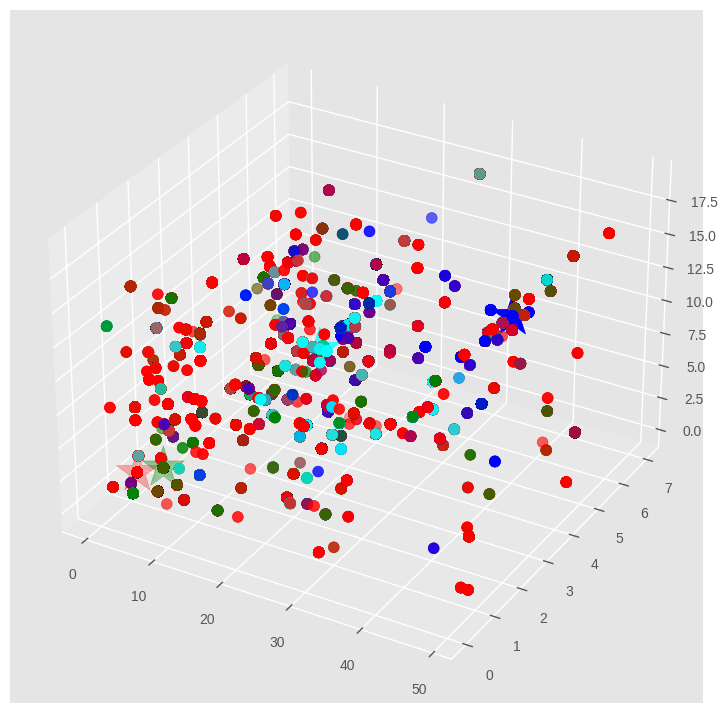

In [ ]:
from numpy.random.mtrand import randint

colores=['red','green','blue','cyan']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 3], X[:, 4], X[:, 5], c=asignar,s=60)
ax.scatter(centroides[:, 3], centroides[:, 4], centroides[:, 5], marker='*', c=colores, s=1000)
plt.show()

### **Agregar columna de clusters**

In [ ]:
df_articles_copy['Cluster No'] = modelo_kmodes.labels_
df_articles_copy.head()

,article_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,Cluster No
0,108775015,121,7,25,1,1,1,82,6,2,43,5,0
1,108775044,121,7,25,47,3,16,82,6,2,43,5,2
2,108775051,121,7,26,29,2,16,82,6,2,43,5,0
3,110065001,15,16,25,1,1,1,43,7,2,46,18,0
4,110065002,15,16,25,47,3,16,43,7,2,46,18,2


#**Exploración del modelo**

In [ ]:
copy =  pd.DataFrame()
copy['article_id']=df_articles_copy['article_id'].values
copy['cluster'] = df_articles_copy['Cluster No'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,51971
1,green,22137
2,blue,17045
3,cyan,13973


In [ ]:
#vemos las posiciones de los representantes del grupo en el array X, los articulos más cercano a cada centroid
closest, _ = pairwise_distances_argmin_min(modelo_kmodes.cluster_centroids_, X)
closest

array([  327,  3088, 74829, 14964])

In [ ]:
# Articulos que están más cerca a los centroids de cada grupo que podríamos decir que tienen atributos que representan a cada cluster
articles=df_articles_copy['article_id'].values
for row in closest:
    print(articles[row])

220094001
448509026
780388004
565200017


In [ ]:
df_articles = pd.read_csv('articles.csv',na_values='?')

In [ ]:
#Representante cluster 0 - red
df_articles[df_articles['article_id']==220094001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
327,220094001,220094,Aguilera maxidress,265,Dress,Garment Full body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Strapless maxi dress in jersey with an elasticated seam at the waist and slits in the sides. Integral top with elastication at the top.


In [ ]:
#Representante cluster 1 - green
df_articles[df_articles['article_id']==448509026]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
3099,448509026,448509,Perrie Slim Mom Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,73,Dark Blue,4,Dark,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,"5-pocket, ankle-length jeans in washed, sturdy cotton denim with a high waist, button fly and slim, straight legs with raw-edge hems."


In [ ]:
#Representante cluster 2 - blue
df_articles[df_articles['article_id']==780388004]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
75243,780388004,780388,Ivar polo,254,Top,Garment Upper body,1010026,Other structure,10,White,3,Light,9,White,2950,Baby Toys/Acc,G,Baby Sizes 50-98,4,Baby/Children,44,Baby Essentials & Complements,1019,Accessories,Polo-neck collar in a soft knit.


In [ ]:
#Representante cluster 3 - cyan
df_articles[df_articles['article_id']==565200017]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
15062,565200017,565200,Mia L/S,255,T-shirt,Garment Upper body,1010016,Solid,51,Light Pink,1,Dusty Light,4,Pink,7616,Kids Girl Jersey Fancy,H,Children Sizes 92-140,4,Baby/Children,76,Kids Girl,1005,Jersey Fancy,Long-sleeved top in printed cotton jersey.


#**Recomendacion a clientes a partir del modelo**

Con el método **recommendations** se busca recomendar dado un usuario, 5 artículos de cada cluster diferente a los que peertenezcan los artículos que haya comprado anteriormente

In [ ]:
def recommendations(clientID):
  df_client = df_merged[df_merged['customer_id']==clientID]
  clusters = []
  df_recomended = pd.DataFrame()   
  articles = pd.DataFrame()   
  for i in df_articles.columns:
    df_recomended[i] = [] 
  for i in df_articles_copy.columns:
    articles[i] = [] 
  for index, transaction in df_client.iterrows():
    ar_id=transaction[1]
    row=df_articles_copy[df_articles_copy["article_id"]==ar_id]
    cluster=row["Cluster No"].values[0]
    clusters.append(cluster)
  unique_clusters = list(set(clusters))
  for cluster in unique_clusters:
    row = df_articles_copy[df_articles_copy["Cluster No"] == cluster].sample(5)
    articles=articles.append(row)
  for index, article in articles.iterrows():
    df_recomended = df_recomended.append(df_articles[df_articles['article_id']==article[0]], ignore_index=True)
  return df_recomended,df_client 

Se prueba con un cliente existente aleatorio

In [ ]:
customer = df_merged.sample(1)["customer_id"].values[0]
print(customer)

b3c22a5440fca0c76802e0dde3c5aaaa98a33e488019586f92af7bd106c90d87


El método **purchasedArticles** permite obtener aquellos artículos que ha comprado el cliente, para comparar aquello que se la ha recomendado con lo que está en su historial de compras

In [ ]:
def purchasedArticles(df):
  df_purchased = pd.DataFrame()
  for i in df_articles.columns:
    df_purchased[i] = [] 
  for index, article in df.iterrows():
    df_purchased = df_purchased.append(df_articles[df_articles['article_id']==article[1]], ignore_index=True)
  return df_purchased  

In [ ]:
df_recomended, df_client = recommendations(customer)

<ipython-input-80-c8ecbac21c6b>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  articles=articles.append(row)
<ipython-input-80-c8ecbac21c6b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recomended = df_recomended.append(df_articles[df_articles['article_id']==article[0]], ignore_index=True)


In [ ]:
df_purchased = purchasedArticles(df_client)
df_purchased.head()

<ipython-input-82-d33e8e64b06a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_purchased = df_purchased.append(df_articles[df_articles['article_id']==article[1]], ignore_index=True)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,706016015.0,706016.0,Jade HW Skinny Denim TRS,272.0,Trousers,Garment Lower body,1010016.0,Solid,8.0,Dark Grey,4.0,Dark,12.0,Grey,1747.0,Trousers,D,Divided,2.0,Divided,53.0,Divided Collection,1009.0,Trousers,"High-waisted jeans in washed superstretch denim with a zip fly and button, fake front pockets, real back pockets and super-skinny legs."


In [ ]:
df_recomended.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,648295001.0,648295.0,Dave Zip Hood CC,308.0,Hoodie,Garment Upper body,1010010.0,Melange,73.0,Dark Blue,4.0,Dark,2.0,Blue,7658.0,Kids Boy Knitwear,H,Children Sizes 92-140,4.0,Baby/Children,46.0,Kids Boy,1003.0,Knitwear,"Jacket in a marled cotton knit with a lined hood, zip down the front with a leather tab, side pockets, and ribbing around the hood, cuffs and hem."
1,516131004.0,516131.0,NIKE 2p (1),273.0,Leggings/Tights,Garment Lower body,1010016.0,Solid,73.0,Dark Blue,4.0,Dark,2.0,Blue,7920.0,Kids Girl Jersey Basic,H,Children Sizes 92-140,4.0,Baby/Children,79.0,Girls Underwear & Basics,1002.0,Jersey Basic,Leggings in sturdy jersey made from an organic cotton blend with an elasticated waist. Soft brushed inside.
2,364297030.0,364297.0,SWEATPANTS OC,272.0,Trousers,Garment Lower body,1010016.0,Solid,73.0,Dark Blue,4.0,Dark,2.0,Blue,6515.0,Baby basics,G,Baby Sizes 50-98,4.0,Baby/Children,44.0,Baby Essentials & Complements,1002.0,Jersey Basic,Trousers in sweatshirt fabric made from organic cotton with an elasticated drawstring waist and ribbed hems. Soft brushed inside.
3,564310010.0,564310.0,Anthony 3pk Fancy,286.0,Underwear bottom,Underwear,1010001.0,All over pattern,73.0,Dark Blue,4.0,Dark,2.0,Blue,7988.0,Underwear Jersey,F,Menswear,3.0,Menswear,26.0,Men Underwear,1017.0,"Under-, Nightwear","Trunks in stretch cotton jersey with flatlock seams, short legs, an elasticated waist and a lined front."
4,613618003.0,613618.0,MC Vermont fancy trs,272.0,Trousers,Garment Lower body,1010004.0,Check,6.0,Light Grey,1.0,Dusty Light,12.0,Grey,1939.0,Woven bottoms,A,Ladieswear,1.0,Ladieswear,2.0,H&M+,1009.0,Trousers,"Ankle-length trousers in woven fabric with a regular waist, concealed hook-and-eye fastener and zip fly. Side pockets, fake welt back pockets and straight legs with creases."
